# Build and simulate DNA
This notebook uses AmberTools and OpenMM to perform a quick molecular dynamics simulation of a small DNA duplex.

In [1]:
%matplotlib inline
from matplotlib.pyplot import *
import moldesign as mdt
from moldesign import units as u

Reading configuration from /Users/aaronvirshup/.moldesign/moldesign.yml


### 1. Set unit system
These will be the default output units for display.

In [2]:
mdt.units.default.energy = u.kcalpermol
mdt.units.default.length = u.nm
mdt.units.default.time = u.ps

### 2. Build a DNA helix

In [2]:
dna_structure = mdt.build_bdna('ACTGACTG')
viewer = dna_structure.draw()
viewer

KeyError: 'helix.pdb'

As you can see, we've got a nice strand of DNA with a bunch of not-so-nice water molecules surrounding it. We'll remove those before going any farther.

### Set up forcefield
Next, we'll assign forcefield parameters to our system. This will also add any missing hydrogens to the molecule.

Notice that, while this runs, a tab named "tleap" will appear under the cell. Go ahead and click on this - it indicates that the tleap command was run remotely using Docker. Especially during "production", it's important to examine the program's logs and understand the meaning of any warnings or errors it emits.

In [5]:
mol = mdt.assign_forcefield(dna_structure)

Exception TypeError: TypeError("'NoneType' object is not callable",) in  ignored


No config file found at /root/.moldesign/moldesign.yml - using defaults


### Set up geometry constraints
Because this a very small piece of DNA, it's likely to unravel as we simulate it. To keep this from happening, let's **freeze the terminal base pairs on each strand**.

**Click on the base pairs to be constrained:**

In [6]:
rs = mdt.ui.ResidueSelector(mol)
rs

In [7]:
for atom in rs.selected_atoms:
    mol.constrain_atom(atom)

Of course, fixing the positions of the terminal base pairs is a fairly extreme step. For extra credit, see if you can find a less heavy-handed keep the terminal base pairs bonded. (Try using tab-completion to see what other constraint methods are available)

## Simulation
We're set up - let's run dynamics! We'll:
 1. Add an OpenMM energy model and a Langevin integrator to our molecule
 1. run a short energy minimization to remove any large instabilities, and
 1. Run 50 ps of dynamics

In [10]:
model = mdt.models.OpenMMPotential(implicit_solvent='obc',
                                  cutoff=5.0*u.angstrom)
integrator = mdt.integrators.OpenMMLangevin(timestep=2.0*u.fs, constraints=['hbonds'],
                                          temperature=300.0*u.kelvin,
                                          frame_interval=1.0*u.ps)
mol.set_energy_model(model)
mol.set_integrator(integrator)

The parameters for the energy model, integrator, and constraints can be reviewed (and modified) at any time:

In [11]:
model.params

{'constrain_hbonds': True,
 'constrain_water': None,
 'cutoff': <Quantity(5.0, 'ang')>,
 'ewald_error': 0.0005,
 'forcefield': None,
 'implicit_solvent': 'obc',
 'nonbonded': 'cutoff',
 'periodic': False,
 'solute_dielectric': 1.0,
 'solvent_dielectric': 78.5}

In [12]:
integrator.params

{'collision_rate': <Quantity(1.0, '1 / ps')>,
 'constraints': ['hbonds'],
 'frame_interval': <Quantity(1.0, 'ps')>,
 'remove_rotation': False,
 'remove_translation': True,
 'temperature': <Quantity(300.0, 'kelvin')>,
 'timestep': <Quantity(2.0, 'fs')>}

In [13]:
for constraint in mol.constraints: print constraint

Nearly every MD simulation should be preceded by an energy minimization, especially for crystal structure data. This will remove any energetically catastrophic clashes between atoms and prevent our simulation from blowing up.

/usr/local/lib/python2.7/dist-packages/simtk/openmm/app/internal/amber_file_parser.py:1010: UserWarning: Non-optimal GB parameters detected for GB model OBC2
  'model %s' % gbmodel)
Exception TypeError: TypeError("'NoneType' object is not callable",) in  ignored


No config file found at /root/.moldesign/moldesign.yml - using defaults
Parsing stored PRMTOP file: In-memory file from string (224812 chars)
Created force field using embedded prmtop file
Created OpenMM kernel (Platform: CPU)
INFO: Copying atoms into new molecule
Reduced energy from -1908.64001687 kcalpermol to -5591.73501216 kcalpermol


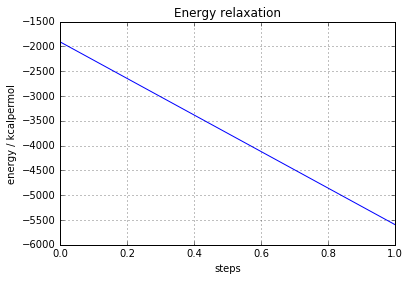

In [14]:
trajectory = mol.minimize(nsteps=200)
plot(trajectory.potential_energy)
xlabel('steps');ylabel('energy / %s'%trajectory.potential_energy.units)
title('Energy relaxation')
grid()
viz = trajectory.draw3d()
viz.licorice()
viz

### Dynamics
We're ready to run 25 picoseconds of dynamics at room temperature (that's 300º Kelvin). This will probably take a few minutes - if you're on an especially pokey computer, you might want to reduce the length of the simulation.

In [20]:
integrator.params.frame_interval=500
traj = mol.run(run_for=25.0*u.ps)

/usr/local/lib/python2.7/dist-packages/simtk/openmm/app/internal/amber_file_parser.py:1010: UserWarning: Non-optimal GB parameters detected for GB model OBC2
  'model %s' % gbmodel)
Exception TypeError: TypeError("'NoneType' object is not callable",) in  ignored


No config file found at /root/.moldesign/moldesign.yml - using defaults
Parsing stored PRMTOP file: In-memory file from string (224812 chars)
Created force field using embedded prmtop file
Created OpenMM kernel (Platform: CPU)
INFO: Copying atoms into new molecule
time / fs                 potential / eV                  kinetic / eV                    T / kelvin
1000.0                    -232.073647465                 17.8635068704                  311.49121828
2000.0                    -230.694648485                 17.7133845443                 308.873491167
3000.0                    -231.566838846                 17.8571804481                 311.380902595
4000.0                    -230.377510424                 17.0106242728                 296.619253815
5000.0                    -231.111674993                 18.4684638222                 322.040030407
6000.0                    -231.875046981                 16.3539212927                 285.168130988
7000.0                    -2

## Analysis
Let's look at the results of our trajectory. The trajectory object (named `traj`) gives us direct access to the timeseries data:

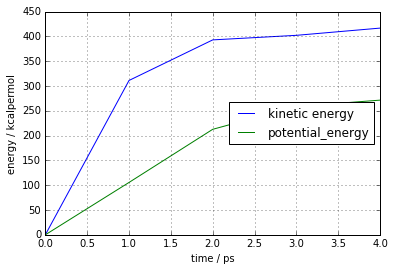

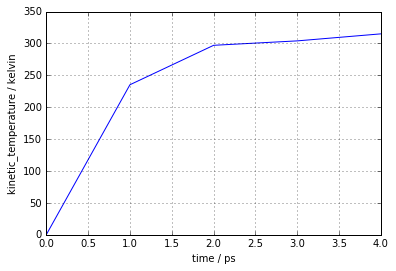

In [16]:
figure()
plot(traj.time, traj.kinetic_energy, label='kinetic energy')
plot(traj.time, traj.potential_energy - traj.potential_energy[0], label='potential_energy')
xlabel('time / {time.units}'.format(time=traj.time))
ylabel('energy / {energy.units}'.format(energy=traj.kinetic_energy))
grid()
legend(loc='center right')

figure()
# Using the trajectory's 'plot' method will autogenerate axes labels with the appropriate units
traj.plot('time','kinetic_temperature')

Of course, it's always nice to see the 3D structure:

In [17]:
viewer = traj.draw3d()
viewer

If you examine the dynamics, you'll likely observe one or more base pairs flipping out of the double helix. They'll be different every time because the simulation uses random numbers to generate the thermal fluctuations.

In the next cell, try plotting the RMSDs of a few base pairs. You can get the residue's names by clicking on them in the trajectory animation.

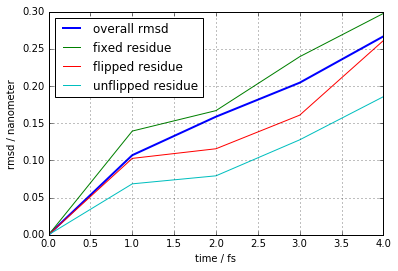

In [19]:
res0 = mol.residues[0]
res1 = mol.residues[2]
res2 = mol.residues[3]

figure()
plot(traj.time, traj.rmsd(), lw=2, label='overall rmsd')
plot(traj.time, traj.rmsd(res0.atoms), label='fixed residue')
plot(traj.time, traj.rmsd(res1.atoms), label='flipped residue')
plot(traj.time, traj.rmsd(res2.atoms), label='unflipped residue')
grid()
xlabel('time / fs')
ylabel(u'rmsd / {}'.format(u.default.length))
legend(loc='upper left')